# Regression Model
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/prediction-fluorination-strength/notebooks/regression-models-4.ipynb)


In [1]:
!pip install rdkit-pypi

In [2]:
!pip install openpyxl

In [3]:
!pip install cairosvg

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw #2D depiction
from rdkit.Chem import rdDepictor #2D coordinate generation, consistency

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Load Data

In [5]:
df_train_data = pd.read_excel('train_data.xlsx')

In [6]:
df_test_data = pd.read_excel('test_data.xlsx')

## Data Scaling

**Scale FPD**


---


In [7]:
fpd_scaler = StandardScaler()
scaled_FPD_train = fpd_scaler.fit_transform(df_train_data[['FPD']])
scaled_FPD_test = fpd_scaler.transform(df_test_data[['FPD']])

In [8]:
scaled_FPD_train_df = pd.DataFrame(scaled_FPD_train, columns=['FPD'])
scaled_FPD_train_df

,FPD
0,-0.245339
1,-0.443028
2,-0.383262
3,-0.590145
4,-0.139598
...,...
209,0.200611
210,-0.098222
211,0.402897
212,-0.029260


In [9]:
scaled_FPD_test_df = pd.DataFrame(scaled_FPD_test, columns=['FPD'])
scaled_FPD_test_df

,FPD
0,-0.521184
1,-0.746458
2,0.646561
3,0.807470
4,0.591391
5,0.715522
6,-5.711671
7,-5.647307
8,1.943033
9,2.494723


In [10]:
scaled_FPD_train_df.to_excel('FPD_train_scaled.xlsx', index=False)

In [11]:
scaled_FPD_test_df.to_excel('FPD_test_scaled.xlsx', index=False)

**Train set**


---


In [12]:
# Initialize the scaler
scaler = StandardScaler()

In [13]:
data_to_scale_test = df_train_data.drop([' Type of Reagent', 'Solvent', 'Name of the Reagent', 'Smiles', 'FPD'], axis=1)

In [14]:
# Scale the features
scaled_train = pd.DataFrame(scaler.fit_transform(data_to_scale_test), columns=data_to_scale_test.columns)

In [15]:
scaled_train

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,AMID_N,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,-0.197066,0.321735,0.286152,0.203969,0.374382,-0.065873,0.052117,0.046095,-0.702978,0.708412,...,1.602427,-0.433833,-1.696002,1.400457,2.669771,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187
1,-0.197066,0.321735,0.286152,0.203969,0.374382,-0.065873,0.052117,0.046095,-0.702978,0.708412,...,1.602427,-0.433833,-1.696002,1.400457,2.669771,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187
2,-0.197066,0.656275,-0.147628,0.765302,0.387213,-0.179775,0.052117,-0.206619,-0.284678,0.580609,...,1.877181,-0.267456,-1.495745,4.729306,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187
3,-0.197066,0.656275,-0.147628,0.765302,0.387213,-0.179775,0.052117,-0.206619,-0.284678,0.580609,...,1.877181,-0.267456,-1.495745,4.729306,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187
4,-0.197066,0.536256,0.189374,0.419899,0.378295,-0.106232,0.052117,0.096731,-0.422700,0.540633,...,1.877181,-0.267456,-1.495745,4.729306,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,-0.197066,0.202439,-1.572842,0.432460,0.329583,-0.096265,0.052117,-1.458483,-0.296935,1.327424,...,-0.044787,1.034199,1.697056,-1.446861,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187
210,-0.197066,0.079904,-0.754225,0.587287,-0.092202,-0.096265,0.052117,-0.741774,0.012776,0.245221,...,-0.182326,0.786265,0.567027,0.007039,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187
211,-0.197066,0.079904,-0.754225,0.587287,-0.092202,-0.096265,0.052117,-0.741774,0.012776,0.245221,...,-0.182326,0.786265,0.567027,0.007039,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187
212,-0.197066,0.056362,-0.859628,0.997637,-0.320134,-0.096265,0.052117,-0.204812,0.405864,-0.863968,...,-0.299321,0.564429,0.521653,-0.395380,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187


In [16]:
scaled_train['Type of Reagent'] = df_train_data[' Type of Reagent']
scaled_train['Solvent'] = df_train_data['Solvent']
scaled_train

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,Type of Reagent,Solvent
0,-0.197066,0.321735,0.286152,0.203969,0.374382,-0.065873,0.052117,0.046095,-0.702978,0.708412,...,-1.696002,1.400457,2.669771,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluoroammoniums,MeCN
1,-0.197066,0.321735,0.286152,0.203969,0.374382,-0.065873,0.052117,0.046095,-0.702978,0.708412,...,-1.696002,1.400457,2.669771,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluoroammoniums,DCM
2,-0.197066,0.656275,-0.147628,0.765302,0.387213,-0.179775,0.052117,-0.206619,-0.284678,0.580609,...,-1.495745,4.729306,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluoroammoniums,MeCN
3,-0.197066,0.656275,-0.147628,0.765302,0.387213,-0.179775,0.052117,-0.206619,-0.284678,0.580609,...,-1.495745,4.729306,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluoroammoniums,DCM
4,-0.197066,0.536256,0.189374,0.419899,0.378295,-0.106232,0.052117,0.096731,-0.422700,0.540633,...,-1.495745,4.729306,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluoroammoniums,MeCN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,-0.197066,0.202439,-1.572842,0.432460,0.329583,-0.096265,0.052117,-1.458483,-0.296935,1.327424,...,1.697056,-1.446861,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluorosulfonimides,DCM
210,-0.197066,0.079904,-0.754225,0.587287,-0.092202,-0.096265,0.052117,-0.741774,0.012776,0.245221,...,0.567027,0.007039,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluorosulfonimides,MeCN
211,-0.197066,0.079904,-0.754225,0.587287,-0.092202,-0.096265,0.052117,-0.741774,0.012776,0.245221,...,0.567027,0.007039,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluorosulfonimides,DCM
212,-0.197066,0.056362,-0.859628,0.997637,-0.320134,-0.096265,0.052117,-0.204812,0.405864,-0.863968,...,0.521653,-0.395380,-1.310025,-0.77445,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluorosulfonimides,MeCN


In [17]:
scaled_train.to_excel('scaled_train.xlsx', index=False)

**Test set**


---


In [18]:
data_to_scale_test = df_test_data.drop([' Type of Reagent', 'Solvent', 'Name of the Reagent', 'Smiles', 'FPD'], axis=1)

In [19]:
data_to_scale_test

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,AMID_N,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,0,-0.027476,0.015512,0.049684,0.011963,0.000000,0.000000,-33.917355,-9.099174,2.082645,...,0.457111,0.111111,0.028846,0.262222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,-0.027476,0.015512,0.049684,0.011963,0.000000,0.000000,-33.917355,-9.099174,2.082645,...,0.457111,0.111111,0.028846,0.262222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,-0.212913,0.174961,-0.141682,0.030300,0.140330,-0.165645,-2.816327,-14.005831,-7.189088,...,0.175668,0.095238,0.048913,0.053333,0.030478,0.019097,0.014248,0.010354,0.009062,0.010597
3,0,-0.212913,0.174961,-0.141682,0.030300,0.140330,-0.165645,-2.816327,-14.005831,-7.189088,...,0.175668,0.095238,0.048913,0.053333,0.030478,0.019097,0.014248,0.010354,0.009062,0.010597
4,0,-0.356338,0.133605,-0.201203,0.087543,0.094537,0.001518,29.647959,-5.530612,-3.872449,...,0.157364,0.086957,0.045000,0.049444,0.029684,0.018022,0.018353,0.012311,0.007049,0.010597
5,0,-0.356338,0.133605,-0.201203,0.087543,0.094537,0.001518,29.647959,-5.530612,-3.872449,...,0.157364,0.086957,0.045000,0.049444,0.029684,0.018022,0.018353,0.012311,0.007049,0.010597
6,0,-0.015593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.103553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0,-0.015593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.103553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0,-0.095833,0.011827,0.001568,-0.023006,0.000000,0.000000,-69.085873,-1.016620,-5.285319,...,0.231900,0.101010,0.041667,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0,-0.095833,0.011827,0.001568,-0.023006,0.000000,0.000000,-69.085873,-1.016620,-5.285319,...,0.231900,0.101010,0.041667,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
# Scale the features
scaled_test = pd.DataFrame(scaler.transform(data_to_scale_test), columns=data_to_scale_test.columns)

In [21]:
scaled_test.head()

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,AMID_N,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,-0.197066,0.723173,0.004864,0.291079,0.391976,-0.096265,0.052117,-0.519382,-0.204820,0.577279,...,1.877181,-0.267456,-1.495745,4.729306,-1.310025,-0.774450,-0.753846,-0.607919,-0.500657,-0.502187
1,-0.197066,0.723173,0.004864,0.291079,0.391976,-0.096265,0.052117,-0.519382,-0.204820,0.577279,...,1.877181,-0.267456,-1.495745,4.729306,-1.310025,-0.774450,-0.753846,-0.607919,-0.500657,-0.502187
2,-0.197066,-0.355975,1.064370,-0.634949,0.487609,0.551215,-1.160767,0.080191,-0.853512,-0.566542,...,-0.272840,-0.719051,-0.752765,-0.190692,0.033582,0.474623,0.850388,0.889843,1.007980,2.557816
3,-0.197066,-0.355975,1.064370,-0.634949,0.487609,0.551215,-1.160767,0.080191,-0.853512,-0.566542,...,-0.272840,-0.719051,-0.752765,-0.190692,0.033582,0.474623,0.850388,0.889843,1.007980,2.557816
4,-0.197066,-1.190627,0.789567,-0.922974,0.786154,0.339927,0.063231,0.706045,0.266966,-0.157380,...,-0.412664,-0.954665,-0.897646,-0.282287,-0.001434,0.404304,1.312593,1.172914,0.672727,2.557816


In [22]:
scaled_test['Type of Reagent'] = df_test_data[' Type of Reagent']
scaled_test['Solvent'] = df_test_data['Solvent']
scaled_test.head()

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,Type of Reagent,Solvent
0,-0.197066,0.723173,0.004864,0.291079,0.391976,-0.096265,0.052117,-0.519382,-0.204820,0.577279,...,-1.495745,4.729306,-1.310025,-0.774450,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluoroammoniums,MeCN
1,-0.197066,0.723173,0.004864,0.291079,0.391976,-0.096265,0.052117,-0.519382,-0.204820,0.577279,...,-1.495745,4.729306,-1.310025,-0.774450,-0.753846,-0.607919,-0.500657,-0.502187,N-Fluoroammoniums,DCM
2,-0.197066,-0.355975,1.064370,-0.634949,0.487609,0.551215,-1.160767,0.080191,-0.853512,-0.566542,...,-0.752765,-0.190692,0.033582,0.474623,0.850388,0.889843,1.007980,2.557816,N-Fluoroammoniums,MeCN
3,-0.197066,-0.355975,1.064370,-0.634949,0.487609,0.551215,-1.160767,0.080191,-0.853512,-0.566542,...,-0.752765,-0.190692,0.033582,0.474623,0.850388,0.889843,1.007980,2.557816,N-Fluoroammoniums,DCM
4,-0.197066,-1.190627,0.789567,-0.922974,0.786154,0.339927,0.063231,0.706045,0.266966,-0.157380,...,-0.897646,-0.282287,-0.001434,0.404304,1.312593,1.172914,0.672727,2.557816,N-Fluoroammoniums,MeCN


In [23]:
scaled_test.to_excel('scaled_test.xlsx', index=False)

## One-hot encoding

**Train set**


---

In [24]:
encoded_train = pd.get_dummies(scaled_train, columns=["Type of Reagent", "Solvent"])
encoded_train.head()

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,JGI9,JGI10,Type of Reagent_N-Fluoroammoniums,Type of Reagent_N-Fluorocarboxamides,Type of Reagent_N-Fluoroheterocycles,Type of Reagent_N-Fluoropyridiniums,Type of Reagent_N-Fluorosulfonamides,Type of Reagent_N-Fluorosulfonimides,Solvent_DCM,Solvent_MeCN
0,-0.197066,0.321735,0.286152,0.203969,0.374382,-0.065873,0.052117,0.046095,-0.702978,0.708412,...,-0.500657,-0.502187,1,0,0,0,0,0,0,1
1,-0.197066,0.321735,0.286152,0.203969,0.374382,-0.065873,0.052117,0.046095,-0.702978,0.708412,...,-0.500657,-0.502187,1,0,0,0,0,0,1,0
2,-0.197066,0.656275,-0.147628,0.765302,0.387213,-0.179775,0.052117,-0.206619,-0.284678,0.580609,...,-0.500657,-0.502187,1,0,0,0,0,0,0,1
3,-0.197066,0.656275,-0.147628,0.765302,0.387213,-0.179775,0.052117,-0.206619,-0.284678,0.580609,...,-0.500657,-0.502187,1,0,0,0,0,0,1,0
4,-0.197066,0.536256,0.189374,0.419899,0.378295,-0.106232,0.052117,0.096731,-0.422700,0.540633,...,-0.500657,-0.502187,1,0,0,0,0,0,0,1


In [25]:
encoded_train.shape

(214, 96)

In [26]:
encoded_train.to_excel('encoded_scaled_train.xlsx', index=False)

**Test set**


---


In [27]:
encoded_test = pd.get_dummies(scaled_test, columns=["Type of Reagent", "Solvent"])
encoded_test.head()

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,JGI9,JGI10,Type of Reagent_N-Fluoroammoniums,Type of Reagent_N-Fluorocarboxamides,Type of Reagent_N-Fluoroheterocycles,Type of Reagent_N-Fluoropyridiniums,Type of Reagent_N-Fluorosulfonamides,Type of Reagent_N-Fluorosulfonimides,Solvent_DCM,Solvent_MeCN
0,-0.197066,0.723173,0.004864,0.291079,0.391976,-0.096265,0.052117,-0.519382,-0.204820,0.577279,...,-0.500657,-0.502187,1,0,0,0,0,0,0,1
1,-0.197066,0.723173,0.004864,0.291079,0.391976,-0.096265,0.052117,-0.519382,-0.204820,0.577279,...,-0.500657,-0.502187,1,0,0,0,0,0,1,0
2,-0.197066,-0.355975,1.064370,-0.634949,0.487609,0.551215,-1.160767,0.080191,-0.853512,-0.566542,...,1.007980,2.557816,1,0,0,0,0,0,0,1
3,-0.197066,-0.355975,1.064370,-0.634949,0.487609,0.551215,-1.160767,0.080191,-0.853512,-0.566542,...,1.007980,2.557816,1,0,0,0,0,0,1,0
4,-0.197066,-1.190627,0.789567,-0.922974,0.786154,0.339927,0.063231,0.706045,0.266966,-0.157380,...,0.672727,2.557816,1,0,0,0,0,0,0,1


In [28]:
encoded_test.shape

(46, 96)

In [29]:
encoded_test.to_excel('encoded_scaled_test.xlsx', index=False)

## Comparing Models

In [30]:
# Extract features and target variable
y_train = scaled_FPD_train_df
X_train = encoded_train

In [31]:
X_train

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,JGI9,JGI10,Type of Reagent_N-Fluoroammoniums,Type of Reagent_N-Fluorocarboxamides,Type of Reagent_N-Fluoroheterocycles,Type of Reagent_N-Fluoropyridiniums,Type of Reagent_N-Fluorosulfonamides,Type of Reagent_N-Fluorosulfonimides,Solvent_DCM,Solvent_MeCN
0,-0.197066,0.321735,0.286152,0.203969,0.374382,-0.065873,0.052117,0.046095,-0.702978,0.708412,...,-0.500657,-0.502187,1,0,0,0,0,0,0,1
1,-0.197066,0.321735,0.286152,0.203969,0.374382,-0.065873,0.052117,0.046095,-0.702978,0.708412,...,-0.500657,-0.502187,1,0,0,0,0,0,1,0
2,-0.197066,0.656275,-0.147628,0.765302,0.387213,-0.179775,0.052117,-0.206619,-0.284678,0.580609,...,-0.500657,-0.502187,1,0,0,0,0,0,0,1
3,-0.197066,0.656275,-0.147628,0.765302,0.387213,-0.179775,0.052117,-0.206619,-0.284678,0.580609,...,-0.500657,-0.502187,1,0,0,0,0,0,1,0
4,-0.197066,0.536256,0.189374,0.419899,0.378295,-0.106232,0.052117,0.096731,-0.422700,0.540633,...,-0.500657,-0.502187,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,-0.197066,0.202439,-1.572842,0.432460,0.329583,-0.096265,0.052117,-1.458483,-0.296935,1.327424,...,-0.500657,-0.502187,0,0,0,0,0,1,1,0
210,-0.197066,0.079904,-0.754225,0.587287,-0.092202,-0.096265,0.052117,-0.741774,0.012776,0.245221,...,-0.500657,-0.502187,0,0,0,0,0,1,0,1
211,-0.197066,0.079904,-0.754225,0.587287,-0.092202,-0.096265,0.052117,-0.741774,0.012776,0.245221,...,-0.500657,-0.502187,0,0,0,0,0,1,1,0
212,-0.197066,0.056362,-0.859628,0.997637,-0.320134,-0.096265,0.052117,-0.204812,0.405864,-0.863968,...,-0.500657,-0.502187,0,0,0,0,0,1,0,1


In [32]:
y_train

,FPD
0,-0.245339
1,-0.443028
2,-0.383262
3,-0.590145
4,-0.139598
...,...
209,0.200611
210,-0.098222
211,0.402897
212,-0.029260


In [33]:
# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "k-Nearest Neighbor": KNeighborsRegressor(),
    "Support Vector Machine": SVR(),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

In [34]:
# Set up a 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
# Store the results with metrics
results = {}

# Evaluate each model using cross-validation
for name, model in models.items():
    scores = []
    rmse_list = []

    # Cross-validation loop
    for train, valid in kf.split(X_train, y_train):
        # Reshape y_train for compatibility
        y_train_1D = y_train.values[train].reshape(-1)
        y_valid_1D = y_train.values[valid].reshape(-1)

        model.fit(X_train.iloc[train], y_train_1D)
        scores.append(model.score(X_train.iloc[valid], y_valid_1D))

        actual = y_valid_1D
        predicted = model.predict(X_train.iloc[valid])

        rmse_list.append(sqrt(mean_squared_error(fpd_scaler.inverse_transform(actual.reshape(-1, 1)), fpd_scaler.inverse_transform(predicted.reshape(-1, 1)))))

    # Train model on the entire dataset
    model.fit(X_train, y_train.values.ravel())
    training_r2 = model.score(X_train, y_train)

    results[name] = {
        "Mean R^2": np.mean(scores),
        "Mean RMSE": np.mean(rmse_list),
        "Training R^2": training_r2
    }

In [36]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by='Mean R^2', ascending=False)

,Mean R^2,Mean RMSE,Training R^2
Random Forest,0.876409,7.487559,0.992575
AdaBoost Regressor,0.822561,8.968137,0.935393
Support Vector Machine,0.820838,8.914014,0.963129
Linear Regression,0.780885,9.397733,0.982582
k-Nearest Neighbor,0.611314,13.273317,0.856607


The Random Forest model performs the best across all metrics. It has the highest R^2 value and the second lowest RMSE after cross-validation.

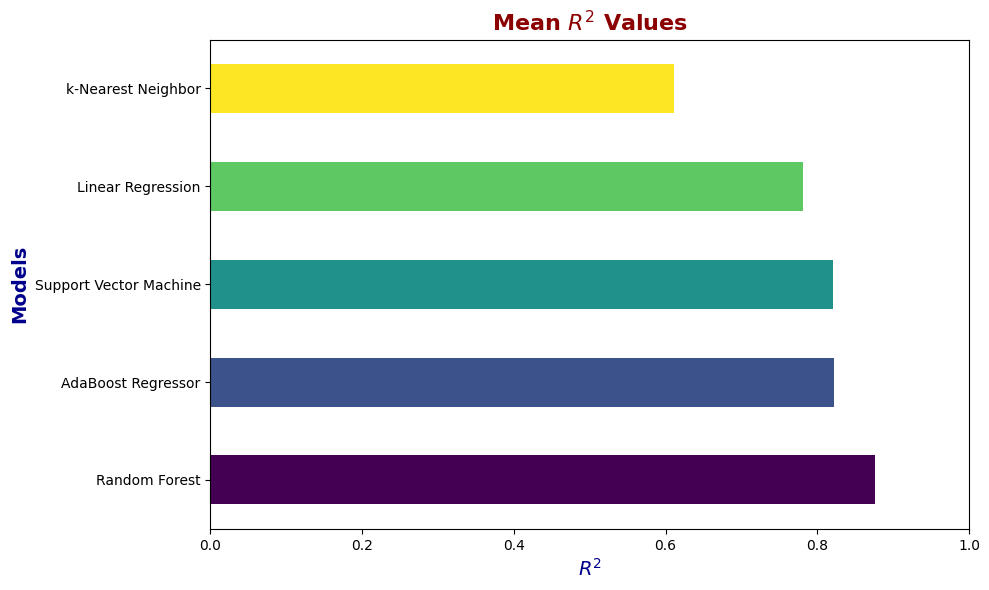

In [37]:
title_font = {"color" : "darkred", "weight" : "bold", "size" : 16}
axis_font = {"color" : "darkblue", "weight" : "bold", "size" : 14}

# Set up the figure
plt.figure(figsize=(10, 6))

# Sort the values
sorted_r2 = results_df['Mean R^2'].sort_values()

# Create colors based on sorted values
colors_r2 = plt.cm.viridis(np.linspace(0, 1, len(sorted_r2)))

# Plot Mean R2 values
sorted_r2 = results_df['Mean R^2'].sort_values(ascending=False)
sorted_r2.plot(kind='barh', color=colors_r2)
plt.title('Mean $R^2$ Values', fontdict=title_font)
plt.xlabel('$R^2$', fontdict=axis_font)
plt.ylabel('Models', fontdict=axis_font)
plt.xlim(0, 1)

#Save to pdf
plt.savefig('R^2_models.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

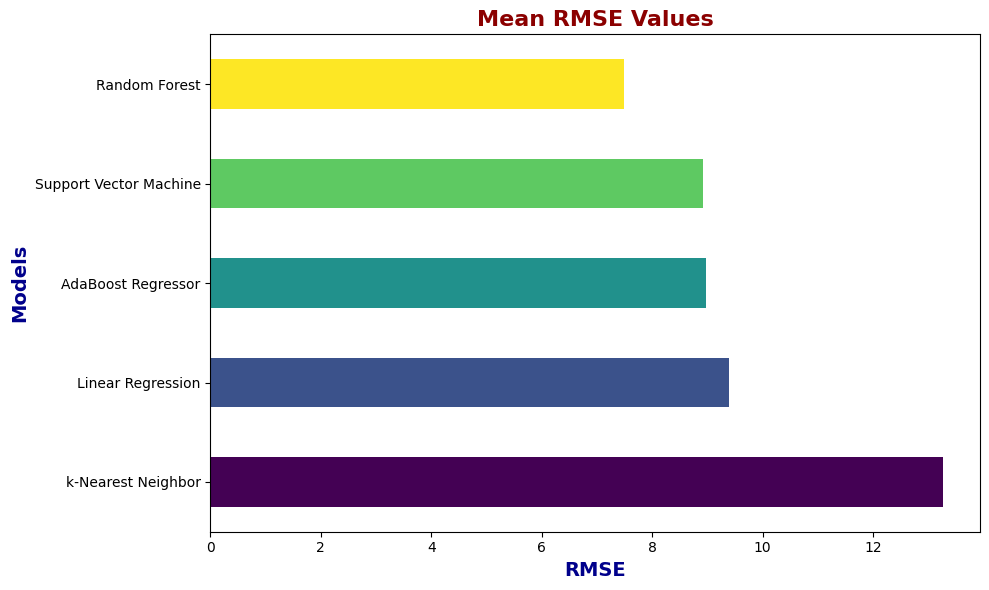

In [38]:
# Set up the figure
plt.figure(figsize = (10, 6))

# Sort the values
sorted_rmse = results_df['Mean RMSE'].sort_values()

# Create colors based on sorted values
colors_rmse = plt.cm.viridis(np.linspace(0, 1, len(sorted_rmse)))

# Plot Mean RMSE values
sorted_rmse = results_df['Mean RMSE'].sort_values(ascending=False)
sorted_rmse.plot(kind='barh', color=colors_rmse)
plt.title('Mean RMSE Values', fontdict=title_font)
plt.xlabel('RMSE', fontdict=axis_font)
plt.ylabel('Models', fontdict=axis_font)

#Save to pdf
plt.savefig('RMSE_models.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

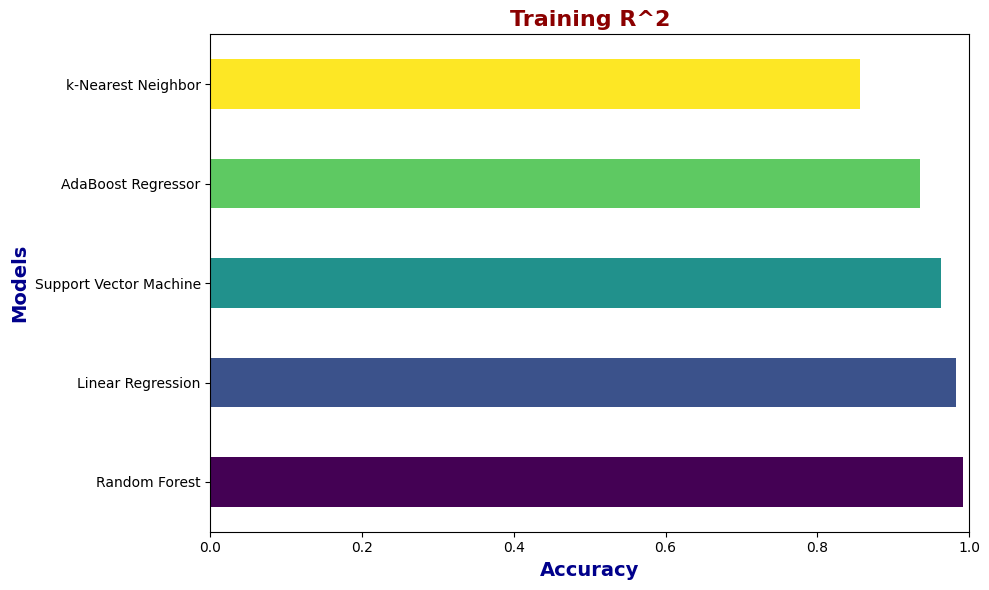

In [39]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Sort the values
sorted_acc = results_df['Training R^2'].sort_values()

# Create colors based on sorted values
colors_acc = plt.cm.viridis(np.linspace(0, 1, len(sorted_acc)))

# Plot Training R^2
sorted_accuracy = results_df['Training R^2'].sort_values(ascending=False)
sorted_accuracy.plot(kind='barh', color=colors_acc)
plt.title('Training R^2', fontdict=title_font)
plt.xlabel('Accuracy', fontdict=axis_font)
plt.ylabel('Models', fontdict=axis_font)
plt.xlim(0, 1)

#Save to pdf
plt.savefig('Training_R2.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

## Feature Importance

In [40]:
# Extract feature importances
feature_importances = models['Random Forest'].feature_importances_

# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
sorted_features_df = features_df.sort_values(by='Importance', ascending=False)
sorted_features_df[:6]

,Feature,Importance
37,BCUTc-1h,0.591254
33,GATS2c,0.047039
28,MATS1c,0.046649
63,SMR_VSA3,0.037366
42,RPCG,0.035910
36,GATS1p,0.020104


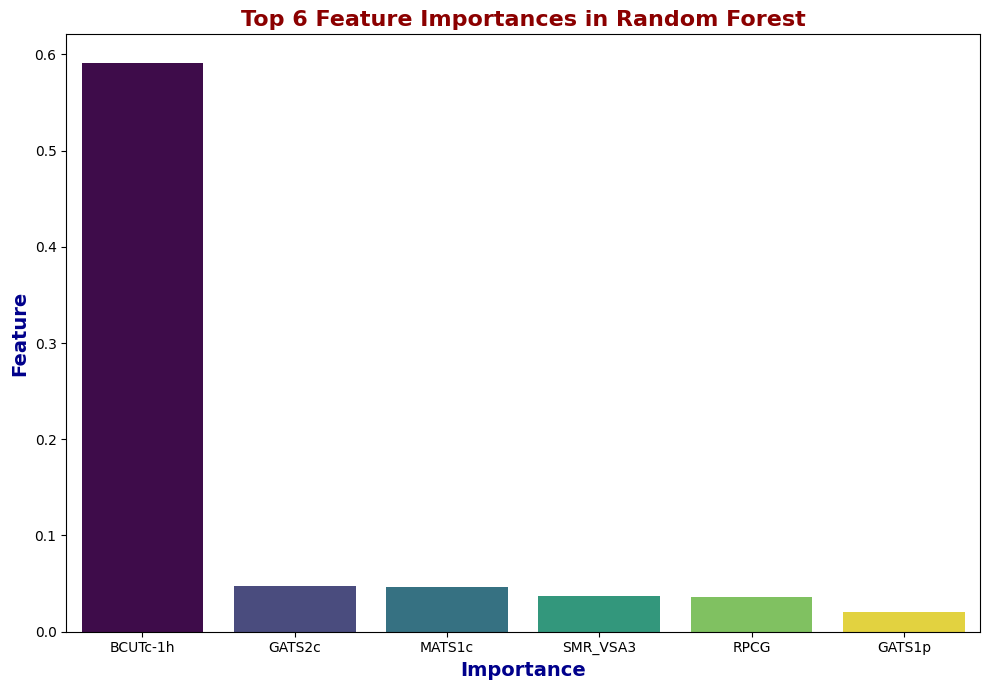

In [41]:
# Set the plot
plt.figure(figsize=(10, 7))

# Set the color
color = plt.cm.viridis(np.linspace(0, 1, 6))

# Plot the top 6 features using seaborn
sns.barplot(y='Importance', x='Feature', data=sorted_features_df.iloc[:6], palette=color)

plt.title('Top 6 Feature Importances in Random Forest', fontdict=title_font)
plt.xlabel('Importance', fontdict=axis_font)
plt.ylabel('Feature',fontdict=axis_font)
plt.xticks

#Save to pdf
plt.savefig('Features_importance.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

The RF model could be tested now with only these 6 features to:
1. Simplify the model and make it simpler and easier to use.
2. Test the performance and assess if so many features are actually needed.

## Predictions

In [42]:
encoded_test.head()

,nSpiro,ATSC1c,ATSC3c,ATSC4c,ATSC5c,ATSC6c,ATSC8c,ATSC4dv,ATSC3d,ATSC4d,...,JGI9,JGI10,Type of Reagent_N-Fluoroammoniums,Type of Reagent_N-Fluorocarboxamides,Type of Reagent_N-Fluoroheterocycles,Type of Reagent_N-Fluoropyridiniums,Type of Reagent_N-Fluorosulfonamides,Type of Reagent_N-Fluorosulfonimides,Solvent_DCM,Solvent_MeCN
0,-0.197066,0.723173,0.004864,0.291079,0.391976,-0.096265,0.052117,-0.519382,-0.204820,0.577279,...,-0.500657,-0.502187,1,0,0,0,0,0,0,1
1,-0.197066,0.723173,0.004864,0.291079,0.391976,-0.096265,0.052117,-0.519382,-0.204820,0.577279,...,-0.500657,-0.502187,1,0,0,0,0,0,1,0
2,-0.197066,-0.355975,1.064370,-0.634949,0.487609,0.551215,-1.160767,0.080191,-0.853512,-0.566542,...,1.007980,2.557816,1,0,0,0,0,0,0,1
3,-0.197066,-0.355975,1.064370,-0.634949,0.487609,0.551215,-1.160767,0.080191,-0.853512,-0.566542,...,1.007980,2.557816,1,0,0,0,0,0,1,0
4,-0.197066,-1.190627,0.789567,-0.922974,0.786154,0.339927,0.063231,0.706045,0.266966,-0.157380,...,0.672727,2.557816,1,0,0,0,0,0,0,1


In [43]:
y_pred = models['Random Forest'].predict(encoded_test)

In [44]:
y_pred

array([-0.36799812, -0.44518881,  0.66490259,  0.89341134,  0.74024665,
        1.04963167, -3.10498019, -3.02760561,  1.85894617,  2.34461762,
       -1.02211905, -0.79725923, -0.53630967, -0.15164354, -0.33622995,
       -0.24644234, -0.93692885, -0.70503499, -0.45406183, -0.23122488,
       -0.84323343, -0.72209141, -0.28722145,  0.0664121 , -0.31250726,
        0.0934909 , -0.71468957, -0.4266612 ,  1.30716381,  1.80005322,
        1.31635865,  1.82124732,  1.22088557,  1.66832947, -0.22924799,
        0.28855943, -0.2643263 ,  0.26828481, -0.42850017,  0.10296158,
       -0.31250726,  0.12323621, -1.25746098, -0.89546012, -1.06956442,
       -0.75344582])

In [45]:
# Reshape y_pred for inverse transformation
y_pred_reshaped = y_pred.reshape(-1, 1)

# Reverse the scaling
reversed_y_pred = fpd_scaler.inverse_transform(y_pred_reshaped)
reversed_y_pred

array([[227.132     ],
       [225.453     ],
       [249.59896429],
       [254.56933333],
       [251.23779762],
       [257.96733333],
       [167.599     ],
       [169.282     ],
       [275.571     ],
       [286.135     ],
       [212.904     ],
       [217.795     ],
       [223.471     ],
       [231.838     ],
       [227.823     ],
       [229.776     ],
       [214.757     ],
       [219.801     ],
       [225.26      ],
       [230.107     ],
       [216.795     ],
       [219.43      ],
       [228.889     ],
       [236.581     ],
       [228.339     ],
       [237.17      ],
       [219.591     ],
       [225.856     ],
       [263.569     ],
       [274.29      ],
       [263.769     ],
       [274.751     ],
       [261.69233333],
       [271.42483333],
       [230.15      ],
       [241.413     ],
       [229.387     ],
       [240.972     ],
       [225.816     ],
       [237.376     ],
       [228.339     ],
       [237.817     ],
       [207.785     ],
       [215

### RMSE and R^2<a name = 25></a>

In [46]:
# Extract actual experimental results
actual_values = df_test_data["FPD"]

# Calculate metrics
rmse_rf = mean_squared_error(actual_values, reversed_y_pred, squared=False)
r2_rf = r2_score(actual_values, reversed_y_pred)

rmse_rf, r2_rf

(13.531301850147441, 0.8292986651851261)

### Scatter Plot<a name = 26></a>

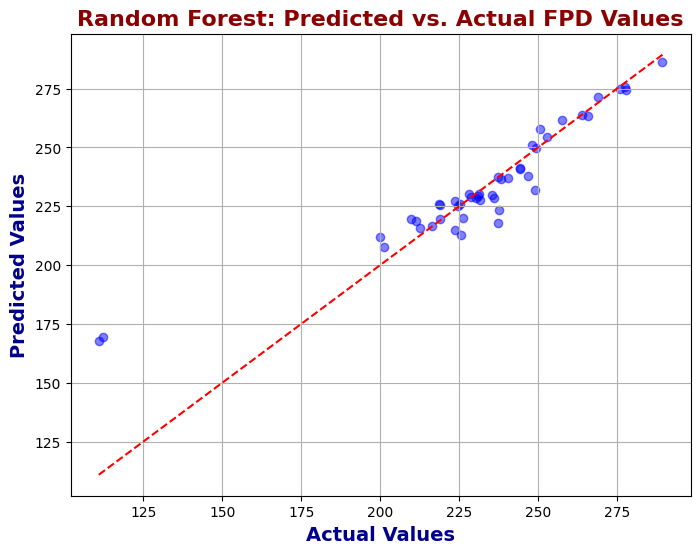

In [57]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, reversed_y_pred, alpha=0.5, color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs. Actual FPD Values', fontdict=title_font)
plt.xlabel('Actual Values', fontdict=axis_font)
plt.ylabel('Predicted Values', fontdict=axis_font)
plt.grid(True)
plt.savefig("RF_predicted_vs_actual.pdf", bbox_inches='tight')
plt.show()

### Residual Plot<a name = 27></a>

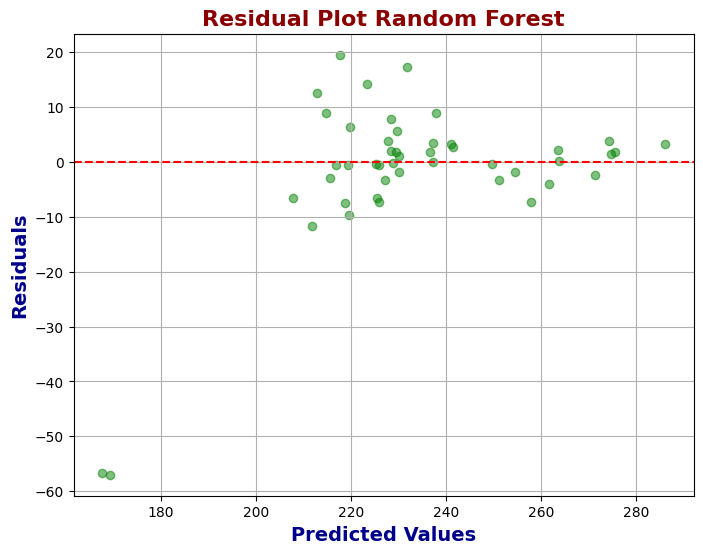

In [48]:
# Residual plot
residuals = actual_values - reversed_y_pred.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(reversed_y_pred, residuals, alpha=0.5, color='green')
plt.title('Residual Plot Random Forest', fontdict=title_font)
plt.xlabel('Predicted Values', fontdict=axis_font)
plt.ylabel('Residuals', fontdict=axis_font)
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.savefig("RF_residuals.pdf", bbox_inches='tight')
plt.show()

### Absolute Difference<a name = 28></a>

In [49]:
# Create a DataFrame with actual and predicted values
comparison_df_rf = pd.DataFrame({
    'Actual Values': actual_values,
    'Predicted Values': reversed_y_pred.flatten(),
    'Absolute Difference': abs(actual_values - reversed_y_pred.flatten())
})

# Display the first few rows of the DataFrame
print(comparison_df_rf.head())

   Actual Values  Predicted Values  Absolute Difference
0          223.8        227.132000             3.332000
1          218.9        225.453000             6.553000
2          249.2        249.598964             0.398964
3          252.7        254.569333             1.869333
4          248.0        251.237798             3.237798


In [50]:
comparison_df_rf.to_excel('test_prediction_random_forest_model.xlsx', index=False)

In [51]:
# Compute summary statistics on the "Difference" column
difference_statistics = comparison_df_rf["Absolute Difference"].describe()

difference_statistics

count    46.000000
mean      7.090665
std      11.652044
min       0.024000
25%       1.746500
50%       3.330000
75%       7.402833
max      56.982000
Name: Absolute Difference, dtype: float64

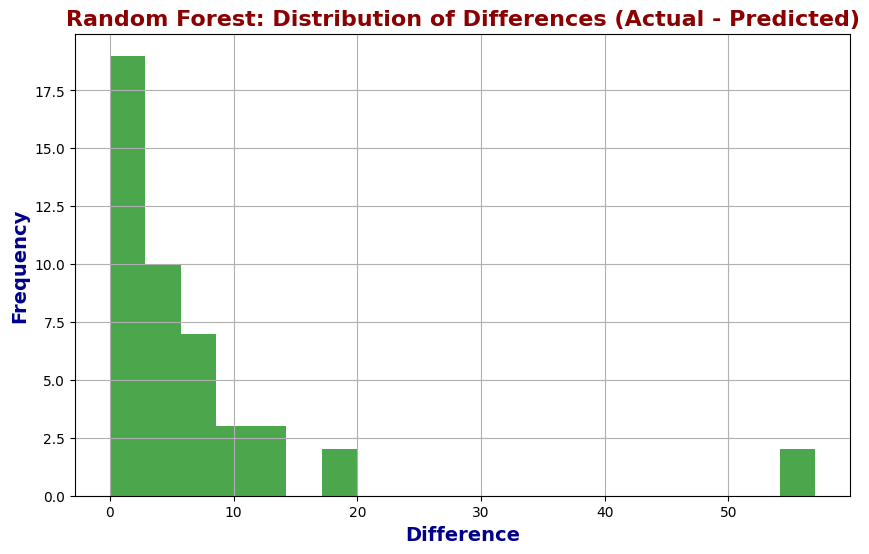

In [52]:
# Histogram of differences
plt.figure(figsize=(10, 6))
plt.hist(comparison_df_rf["Absolute Difference"], bins=20, color='green', alpha=0.7)
plt.title('Random Forest: Distribution of Differences (Actual - Predicted)', fontdict=title_font)
plt.xlabel('Difference', fontdict=axis_font)
plt.ylabel('Frequency', fontdict=axis_font)
plt.grid(True)
plt.savefig("RF_difference.pdf", bbox_inches='tight')

plt.show()

In [53]:
test_molecules_df = pd.concat([df_test_data[['Smiles', ' Type of Reagent']], comparison_df_rf], axis=1)

In [54]:
test_molecules_df

,Smiles,Type of Reagent,Actual Values,Predicted Values,Absolute Difference
0,F[N+]1(CC2)CC[N+]2(F)CC1,N-Fluoroammoniums,223.8,227.132000,3.332000
1,F[N+]1(CC2)CC[N+]2(F)CC1,N-Fluoroammoniums,218.9,225.453000,6.553000
2,O[C@@H](C1=C(C=C(OC)C=C2)C2=NC=C1)[C@@H]3[N@@+...,N-Fluoroammoniums,249.2,249.598964,0.398964
3,O[C@@H](C1=C(C=C(OC)C=C2)C2=NC=C1)[C@@H]3[N@@+...,N-Fluoroammoniums,252.7,254.569333,1.869333
4,F[N@+]1(C[C@H]2CC)[C@@H]([C@@H](OC(C)=O)C3=C(C...,N-Fluoroammoniums,248.0,251.237798,3.237798
5,F[N@+]1(C[C@H]2CC)[C@@H]([C@@H](OC(C)=O)C3=C(C...,N-Fluoroammoniums,250.7,257.967333,7.267333
6,N#[N+]F,N-Fluoroammoniums,110.9,167.599000,56.699000
7,N#[N+]F,N-Fluoroammoniums,112.3,169.282000,56.982000
8,FN1C(CCCCC1)=O,N-Fluorocarboxamides,277.4,275.571000,1.829000
9,FN1C(CCCCC1)=O,N-Fluorocarboxamides,289.4,286.135000,3.265000


,Smiles,Type of Reagent,Actual Values,Predicted Values,Absolute Difference,ROMol
0,F[N+]1(CC2)CC[N+]2(F)CC1,N-Fluoroammoniums,223.8,227.132000,3.332000,
1,F[N+]1(CC2)CC[N+]2(F)CC1,N-Fluoroammoniums,218.9,225.453000,6.553000,
2,O[C@@H](C1=C(C=C(OC)C=C2)C2=NC=C1)[C@@H]3[N@@+...,N-Fluoroammoniums,249.2,249.598964,0.398964,
3,O[C@@H](C1=C(C=C(OC)C=C2)C2=NC=C1)[C@@H]3[N@@+...,N-Fluoroammoniums,252.7,254.569333,1.869333,
4,F[N@+]1(C[C@H]2CC)[C@@H]([C@@H](OC(C)=O)C3=C(C...,N-Fluoroammoniums,248.0,251.237798,3.237798,
5,F[N@+]1(C[C@H]2CC)[C@@H]([C@@H](OC(C)=O)C3=C(C...,N-Fluoroammoniums,250.7,257.967333,7.267333,
6,N#[N+]F,N-Fluoroammoniums,110.9,167.599000,56.699000,
7,N#[N+]F,N-Fluoroammoniums,112.3,169.282000,56.982000,
8,FN1C(CCCCC1)=O,N-Fluorocarboxamides,277.4,275.571000,1.829000,
9,FN1C(CCCCC1)=O,N-Fluorocarboxamides,289.4,286.135000,3.265000,

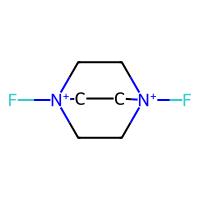
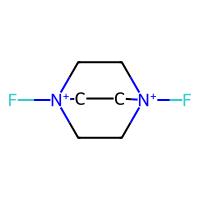
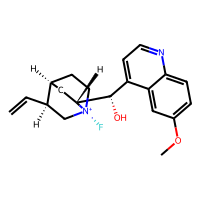
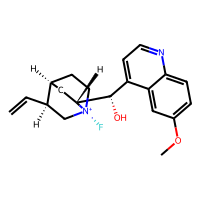
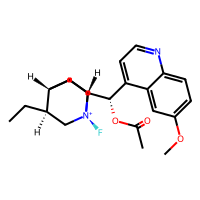
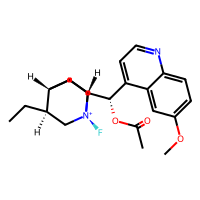
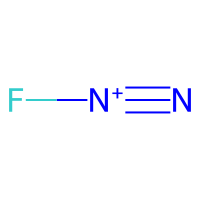
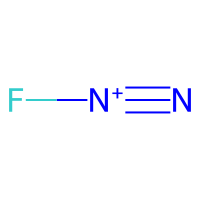
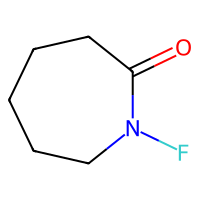
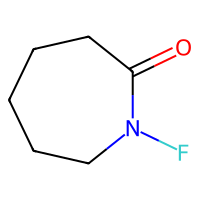
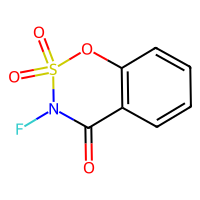
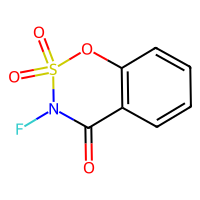
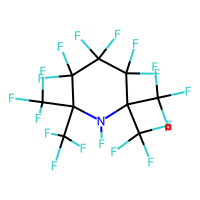
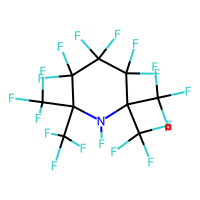
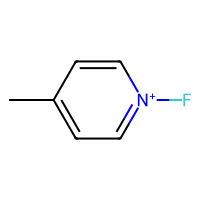
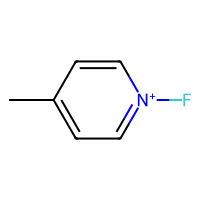
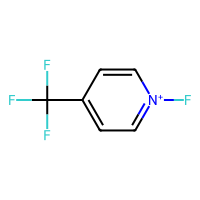
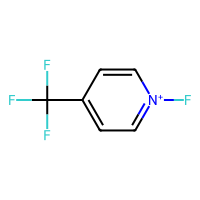
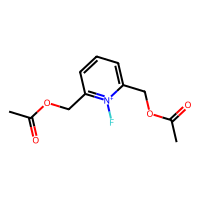
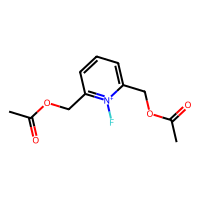
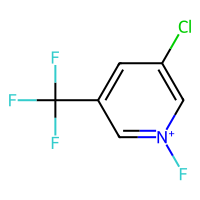
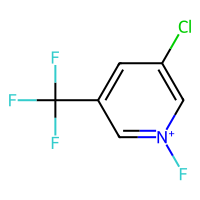
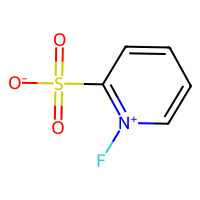
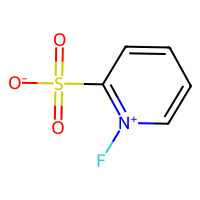
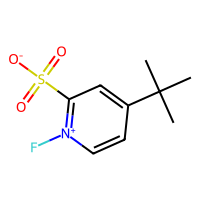
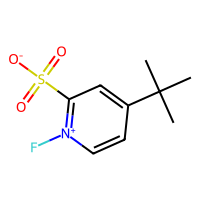
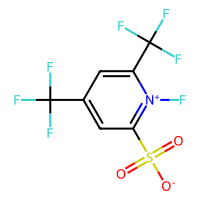
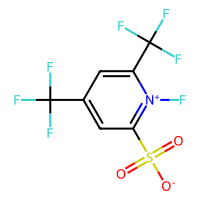
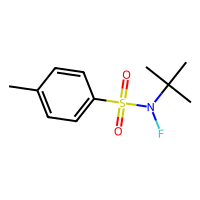
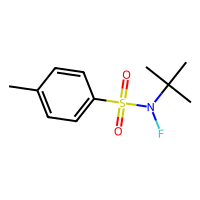
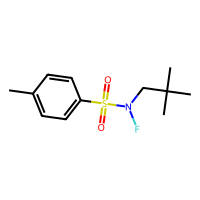
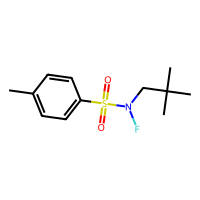
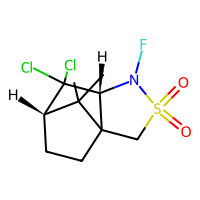
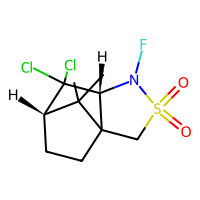
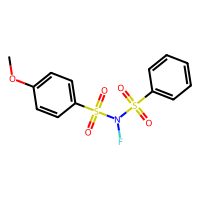
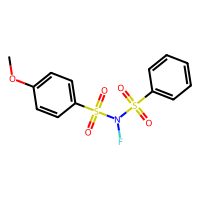
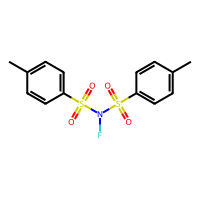
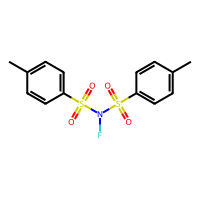
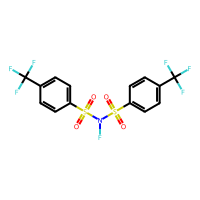
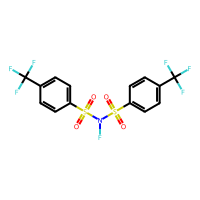
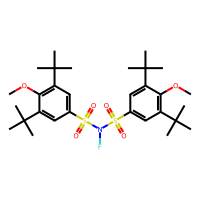
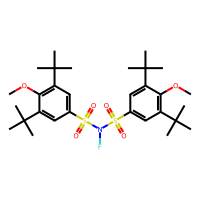
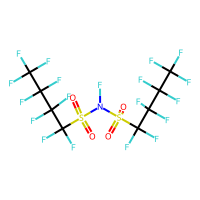
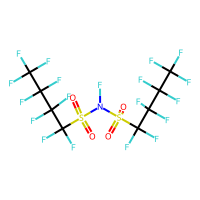
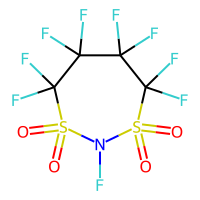
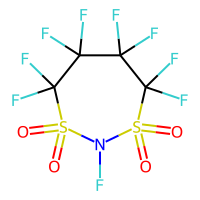

In [55]:
# using pandastools to create molecule from smiles within the dataframe
PandasTools.AddMoleculeColumnToFrame(test_molecules_df, smilesCol="Smiles")
test_molecules_df

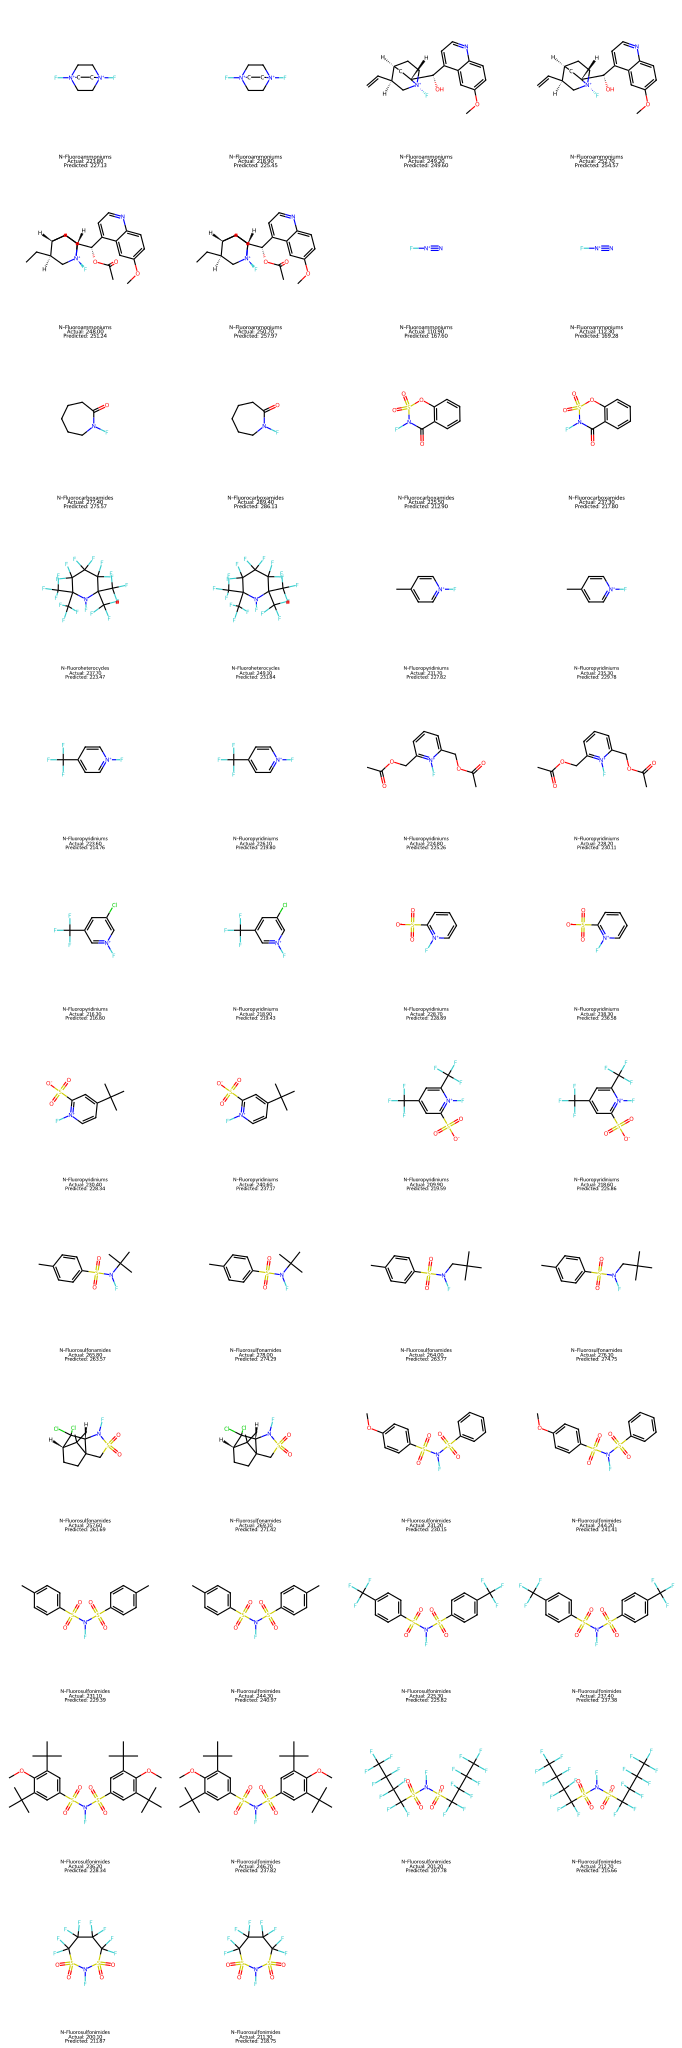

In [56]:
from rdkit.Chem import Draw
import cairosvg

# Step 1: Create the legends list
legends = test_molecules_df.apply(lambda row: f"{row[' Type of Reagent']}\nActual: {row['Actual Values']:.2f}\nPredicted: {row['Predicted Values']:.2f}", axis=1).tolist()

# Step 2: Generate the SVG image
img_svg = Draw.MolsToGridImage(test_molecules_df['ROMol'],
                               subImgSize=(300,300),
                               molsPerRow=4,
                               legends=legends,
                               useSVG=True)


# Save the SVG image to a file
svg_filename = "Molecules_predicted_vs_Observed.svg"
with open(svg_filename, "w") as f:
    f.write(img_svg.data)


# Convert the SVG to PDF
pdf_filename = svg_filename.replace(".svg", ".pdf")
cairosvg.svg2pdf(url=svg_filename, write_to=pdf_filename)

# Display the generated image
img_svg

## Conclusions

During the development of this project, I aimed to reproduce the results observed by the author of the publication on predicting the fluorination strength of electrophilic fluorinating reagents. To achieve this, I began by examining the original dataset presented in the publication, where 130 different molecules were selected in two solvents: MeOH and DCM.

I utilized the RDKit library, which is applied in cheminformatics, along with mordred for molecular fingerprints. For visualization and data processing, I used libraries such as matplotlib, seaborn, pandas, and numpy. The machine learning modeling was conducted with the scikit-learn library.

* <u>**Steps for Data preprocessing:**</u>

1. **Calculation of Molecular Descriptors using Mordred:** At this step, I calculated 1826 molecular fingerprints which were later reduced to 88 after feature engineering.
2. **Feature Engineering:**
- 2.1. Elimination of missing values
- 2.2. Correlation-based variable reduction
- 2.3. Elimination of features with constant values
- 2.4. Visualization: Descriptors were visualized in relation to the Type of Reagent class after reducing dimensionality with t-SNE and PCA.

* <u>**Machine Learning Model:**</u>

1. **I compared five models:** Linear Regression, k-Nearest Neighbor, Support Vector Machine, AdaBoost Regressor, and Random Forest Regressor using five-fold cross-validation. **The best model** was the Random Forest with R^2 = 0.88 and RMSE = 7.48. For comparison, the author achieved an R2 and RMSE of 0.93 and 6.94, respectively, for the Random Forest Regressor. Subsequent predictions were made using the test set. My results were R2 = 0.83 and RMSE = 13.5, while the author achieved R2 = 0.78 and RMSE = 9.64. The maximum difference between observed and predicted was 56.98, and the minimum was 0.02.

2. Lastly, **feature importance** was also calculated. One feature, the **BCUTc-1h** fingerprint, stood out with a score of 0.591254. This was evidently the most significant feature for the regression model. It was followed by **GATS2c, MATS1c, SMR_VSA3, RPCG and GATS1p** with importances of 0.047039, 0.046649, 0.037366, 0.035910, and 0.020104, respectively. In this domain, there are further opportunities for exploration, such as re-running the model while focusing solely on the most important features.

Overall, the model predicted the test set reasonably well, and I successfully replicated most of the implementation that the author used in the development of her project.